In [81]:
import logging
from dataclasses import dataclass
from enum import Enum
from typing import Optional, Type
import matplotlib as mpl
import json
import sys
import numpy as np
import tables
import os
import matplotlib.pyplot as plt

In [41]:
logging.root.setLevel(logging.INFO)

In [70]:
from phd.utils.histogram_pb2 import Histogram2DList

In [77]:
path = "/home/zelenyy/npm/phd/phd-code/cxx/thunderstorm/run/histogram4.bin"

histLis = Histogram2DList()

In [78]:
import struct

with open(path, "rb") as fin:
    size = struct.unpack("i", fin.read(4))[0]
    size
    histLis.ParseFromString(fin.read(size))

In [87]:
class ProtoList:
    def __init__(self, path, topClass: Type):
        self.path = path
        self.topClass = topClass
        
    def __enter__(self):
        self.fin = open(self.path, "rb")
        buff = self.fin.read(4)
        if buff == b"": raise Exception("Empty file")
        size = struct.unpack("i", buff)[0]
        self.messege_sizes = [size]
        self.coords = [0]
        coord = 0
        while True:
            coord = 4 + size
            self.fin.seek(coord)
            self.coords.append(coord)
            buff = self.fin.read(4)
            if buff == b"": break
            size = struct.unpack("i", buff)[0]
            self.messege_sizes.append(size)
             
        return self
    
    def __getitem__(self, item):
        self.fin.seek(self.coords[item] + 4)
        data = self.fin.read(self.messege_sizes[item])
        protoClass = self.topClass()
        protoClass.ParseFromString(data)
        return protoClass
    
    def __exit__(self, exc_type, exc_val, exc_tb):
        self.fin.close()

In [88]:
with ProtoList(path, Histogram2DList) as protoList:
    print(protoList[1])
   
    
        

histogram {
  data: 94
  data: 116
  data: 134
  data: 173
  data: 241
  data: 204
  data: 195
  data: 159
  data: 159
  data: 120
  data: 80
  data: 96
  data: 70
  data: 65
  data: 52
  data: 49
  data: 49
  data: 34
  data: 27
  data: 24
  data: 19
  data: 24
  data: 9
  data: 22
  data: 11
  data: 12
  data: 3
  data: 6
  data: 6
  data: 4
  data: 2
  data: 3
  data: 7
  data: 4
  data: 3
  data: 0
  data: 0
  data: 0
  data: 0
  data: 0
  data: 30
  data: 34
  data: 39
  data: 55
  data: 63
  data: 74
  data: 75
  data: 46
  data: 53
  data: 47
  data: 30
  data: 33
  data: 19
  data: 23
  data: 14
  data: 11
  data: 12
  data: 8
  data: 8
  data: 11
  data: 9
  data: 7
  data: 7
  data: 5
  data: 1
  data: 3
  data: 4
  data: 1
  data: 2
  data: 2
  data: 1
  data: 0
  data: 0
  data: 1
  data: 0
  data: 0
  data: 0
  data: 0
  data: 0
  data: 0
  data: 22
  data: 17
  data: 18
  data: 36
  data: 44
  data: 32
  data: 30
  data: 39
  data: 16
  data: 21
  data: 20
  data: 21
  da

In [ ]:
from tables import File, Group, Table
path = "/home/zelenyy/data/thunderstorm/test_probability_dwyer/result.hdf5"

In [64]:
class PDGID(Enum):
    GAMMA = 22
    ELECTRON = 11
    POSITRON = -11

class WeightHistogramm:
    def __init__(self, bins_x, bins_y, data):
        self.bins_x = bins_x
        self.bins_y = bins_y
        self.data = data
    
    def get_weight(self, x, y) -> float:
        xc = np.argmax(self.bins_x>x) - 1
        yc = np.argmax(self.bins_y>y) - 1
        return self.data[xc,yc]
    
    @staticmethod
    def from_file(h5file: File, group: Group, tracking_table: Table, particle : PDGID):
        bins_x = h5file.get_node(group, "xbins").read()
        bins_y = h5file.get_node(group, "ybins").read()
        table = h5file.get_node(group, "histByEvent")
        data = table.read(table.nrows-1)['histogramm'][0]
        
        energy_min = np.min(bins_x)
        energy_max = np.max(bins_x)
        
        condition="(energy > {}) & (energy <= {}) & (particle == {})".format(energy_min, energy_max, particle.value)
        logging.debug("Using condition to selection: " + condition)
        data_tracking = tracking_table.read_where(condition)
        
        accepted = np.histogram2d(data_tracking["energy"], data_tracking["z"], bins=(bins_x, bins_y))[0]
        weight = data/accepted
        return WeightHistogramm(bins_x, bins_y, weight)



@dataclass
class HistDispatcher:
    gamma_low : WeightHistogramm
    gamma_high: WeightHistogramm
    electron_low: WeightHistogramm
    electron_high: WeightHistogramm
    
    def get_hist(self, particle) -> Optional[WeightHistogramm]:
        """
        PDGID
        electron = 11
        positron = -11
        gamma = 22
        :param particle: 
        :return: 
        """
        if particle["particle"] == PDGID.GAMMA.value:
            if particle["energy"] < 1.0:
                return self.gamma_low
            else:
                return self.gamma_high
        elif particle["particle"] == PDGID.ELECTRON.value:
            if particle["energy"] < 1.0:
                return self.electron_low
            else:
                return self.electron_high
        elif particle["particle"] == PDGID.ELECTRON.value:
            return None
        else:
            return None
    @staticmethod
    def from_file(h5file, group):
        
        tracking_table = h5file.get_node(group, "TreeTracking")
        
        group_hist = h5file.get_node(group, "histDwyer2003")
        group_gamma_low = h5file.get_node(group_hist, "gamma_low")
        gamma_low = WeightHistogramm.from_file(h5file, group_gamma_low, tracking_table, PDGID.GAMMA)
        
        group_gamma_high = h5file.get_node(group_hist, "gamma_high")
        gamma_high = WeightHistogramm.from_file(h5file, group_gamma_high, tracking_table, PDGID.GAMMA)

        group_electron_low = h5file.get_node(group_hist, "electron_low")
        electron_low = WeightHistogramm.from_file(h5file, group_electron_low, tracking_table, PDGID.ELECTRON)        

        group_electron_high = h5file.get_node(group_hist, "electron_high")
        electron_high = WeightHistogramm.from_file(h5file, group_electron_high, tracking_table, PDGID.ELECTRON)
        
        return HistDispatcher(gamma_low, gamma_high, electron_low, electron_high)

In [65]:
with tables.open_file(path) as h5file:
    group =h5file.get_node(h5file.root, "sim0001")
    hist_dispatcher = HistDispatcher.from_file(h5file, group)
    

/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/home/zelenyy/miniconda3/envs/phd-code/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


In [67]:
def find_chain(data, parent_id):
    result = []
    parent_indx = np.where(data["id"] == parent_id)[0][0]
    next_parent_id = data[parent_indx]["parent_id"]
    result.append(data[parent_indx])
    if next_parent_id == 0:
        return []
    result += find_chain(data, next_parent_id) 
    return result

def count_track_weight(data, data_final, hist_dispatcher: HistDispatcher):
    weights = []
    for final in data_final:
        chain = find_chain(data, final["parent_id"])
        weight = 1
        for item in chain:
            if item["particle"] == PDGID.POSITRON.value:
                continue
            hist = hist_dispatcher.get_hist(item)
            weight *= hist.get_weight(item["energy"], item["z"])
        weights.append(weight)
    return weights


In [38]:
with tables.open_file(path) as h5file:
    data = h5file.get_node(h5file.root, "sim0001/TreeTracking").read()
    data_gamma =h5file.get_node(h5file.root, "sim0001/gamma").read()

In [44]:
chain = find_chain(data, data_gamma["parent_id"][0])

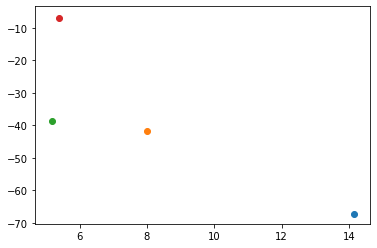

In [45]:
for item in chain:
    plt.scatter(item["radius"],item["z"])

In [68]:
gamma_weights = count_track_weight(data, data_gamma, hist_dispatcher)

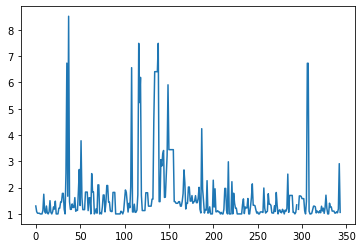

In [69]:
plt.plot(gamma_weights)

In [53]:
data.dtype

dtype([('id', '<i4'), ('parent_id', '<i4'), ('particle', '<i4'), ('zero', '<i4'), ('energy', '<f8'), ('theta', '<f8'), ('radius', '<f8'), ('z', '<f8')])

In [ ]:
hist_dispatcher.gamma_low.data

In [6]:
with tables.open_file(path) as h5file:
    table =h5file.get_node(h5file.root, "sim0001/histDwyer2003/electron_high/xbins")
    print(repr(table.attrs))

/sim0001/histDwyer2003/electron_high/xbins._v_attrs (AttributeSet), 6 attributes:
   [CLASS := 'ARRAY',
    FLAVOR := 'numpy',
    TITLE := '',
    VERSION := '2.4',
    type := 'energy',
    unit := 'MeV']


In [21]:
condition="(energy > 1) & (energy <= 5) & (particle == 22)"
with tables.open_file(path) as h5file:
    table =h5file.get_node(h5file.root, "sim0001/TreeTracking")
    data = table.read_where(condition)
    print(data.dtype)

[('id', '<i4'), ('parent_id', '<i4'), ('particle', '<i4'), ('zero', '<i4'), ('energy', '<f8'), ('theta', '<f8'), ('radius', '<f8'), ('z', '<f8')]
